# Latent Diffusion Model

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import requests
import zipfile
from tqdm.auto import tqdm
import gc
import logging
from accelerate import Accelerator
from transformers import CLIPProcessor, CLIPModel
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler, StableDiffusionPipeline
import matplotlib.pyplot as plt
import shutil

## Intialize Logger

In [ ]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## Flickr-8k Dataset Class

In [ ]:
class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, captions_file, clip_processor, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.clip_processor = clip_processor

        with open(captions_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()

        self.data = []
        for line in lines:
            if not line.strip():
                continue
            try:
                parts = line.strip().split('#')
                image_name = parts[0].strip()
                caption = ' '.join(parts[1].split()[1:])
                img_path = os.path.join(image_dir, image_name)
                if os.path.exists(img_path):
                    self.data.append((image_name, caption))
            except Exception as e:
                logger.error(f"Error processing line: {line}, Error: {str(e)}")

        logger.info(f"Loaded {len(self.data)} valid image-caption pairs")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, caption = self.data[idx]
        image_path = os.path.join(self.image_dir, image_name)
        try:
            image = Image.open(image_path).convert('RGB')
            processed = self.clip_processor(
                text=[caption],
                images=image,
                return_tensors="pt",
                padding=True,
                truncation=True
            )

            return {
                "pixel_values": processed["pixel_values"][0].clone(),  # Add clone()
                "input_ids": processed["input_ids"][0].clone(),        # Add clone()
                "attention_mask": processed["attention_mask"][0].clone()  # Add clone()
            }
        except Exception as e:
            logger.error(f"Error loading image {image_path}: {str(e)}")
            return None

## Downloading the Flickr-8k Dataset

In [ ]:
def download_dataset(save_dir='dataset'):
    """Download and extract Flickr8k dataset with proper path handling"""
    os.makedirs(save_dir, exist_ok=True)

    # Download and extract image dataset
    image_zip = os.path.join(save_dir, "Flickr8k_Dataset.zip")
    if not os.path.exists(os.path.join(save_dir, 'Flicker8k_Dataset')):
        logger.info("Downloading image dataset...")
        try:
            response = requests.get(
                'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
                stream=True
            )
            response.raise_for_status()

            total_size = int(response.headers.get('content-length', 0))
            with open(image_zip, 'wb') as f:
                for data in tqdm(
                    response.iter_content(chunk_size=8192),
                    total=total_size // 8192,
                    desc="Downloading images"
                ):
                    f.write(data)

            logger.info("Extracting image dataset...")
            with zipfile.ZipFile(image_zip, 'r') as zip_ref:
                zip_ref.extractall(save_dir)
            os.remove(image_zip)
        except Exception as e:
            logger.error(f"Failed to download or extract image dataset: {str(e)}")
            return False

    # Download and extract text dataset
    text_zip = os.path.join(save_dir, "Flickr8k_text.zip")
    if not os.path.exists(os.path.join(save_dir, 'Flicker8k_Dataset', 'Flickr8k.token.txt')):
        logger.info("Downloading text dataset...")
        try:
            response = requests.get(
                'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
                stream=True
            )
            response.raise_for_status()

            total_size = int(response.headers.get('content-length', 0))
            with open(text_zip, 'wb') as f:
                for data in tqdm(
                    response.iter_content(chunk_size=8192),
                    total=total_size // 8192,
                    desc="Downloading text data"
                ):
                    f.write(data)

            logger.info("Extracting text dataset...")
            with zipfile.ZipFile(text_zip, 'r') as zip_ref:
                contents = zip_ref.namelist()
                token_file = next((name for name in contents if name.endswith('token.txt')), None)

                if token_file is None:
                    raise RuntimeError("Could not find token.txt in the archive")

                temp_dir = os.path.join(save_dir, 'temp')
                os.makedirs(temp_dir, exist_ok=True)
                zip_ref.extract(token_file, temp_dir)

                src_token = os.path.join(temp_dir, token_file)
                dst_token = os.path.join(save_dir, 'Flicker8k_Dataset', 'Flickr8k.token.txt')
                os.makedirs(os.path.dirname(dst_token), exist_ok=True)
                shutil.copy2(src_token, dst_token)

                shutil.rmtree(temp_dir)
            os.remove(text_zip)
        except Exception as e:
            logger.error(f"Failed to download or extract text dataset: {str(e)}")
            return False

    # Verify all required paths exist
    required_paths = [
        os.path.join(save_dir, 'Flicker8k_Dataset'),
        os.path.join(save_dir, 'Flicker8k_Dataset', 'Flickr8k.token.txt')
    ]

    for path in required_paths:
        if not os.path.exists(path):
            logger.error(f"Required path not found: {path}")
            return False

    logger.info("Dataset preparation completed successfully")
    return True

In [ ]:
if not download_dataset():
    raise RuntimeError("Dataset preparation failed")

## Setup Training

In [ ]:
def setup_training(device):
    """Initialize models with CLIP fine-tuning setup"""
    logger.info("Loading models...")

    # Load CLIP model for fine-tuning
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    # Load frozen VAE and U-Net
    vae = AutoencoderKL.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        subfolder="vae"
    ).to(device)
    unet = UNet2DConditionModel.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        subfolder="unet"
    ).to(device)

    # Freeze VAE and U-Net
    vae.requires_grad_(False)
    unet.requires_grad_(False)

    # Unfreeze CLIP for fine-tuning
    clip_model.requires_grad_(True)

    return clip_model, clip_processor, vae, unet

## Collate Function for collating data into batches

In [ ]:
def collate_fn(batch):
    # Filter out None values
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        raise RuntimeError("Empty batch")

    # Find max length in the batch
    max_length = max(x["input_ids"].size(0) for x in batch)

    # Pad input_ids and attention_mask
    padded_input_ids = []
    padded_attention_mask = []
    pixel_values = []

    for item in batch:
        # Get current length
        curr_len = item["input_ids"].size(0)
        # Pad input_ids
        padding = torch.zeros(max_length - curr_len, dtype=item["input_ids"].dtype)
        padded_input_ids.append(torch.cat([item["input_ids"], padding]))
        # Pad attention_mask
        mask_padding = torch.zeros(max_length - curr_len, dtype=item["attention_mask"].dtype)
        padded_attention_mask.append(torch.cat([item["attention_mask"], mask_padding]))
        # Add pixel values
        pixel_values.append(item["pixel_values"])

    return {
        "pixel_values": torch.stack(pixel_values),
        "input_ids": torch.stack(padded_input_ids),
        "attention_mask": torch.stack(padded_attention_mask)
    }

## Training the model

In [ ]:
def train(accelerator, clip_model, train_dataloader, num_epochs=10):
    train_losses = []  # Store batch-wise losses
    epoch_losses = []  # Store epoch-wise losses

    optimizer = torch.optim.AdamW(clip_model.parameters(), lr=1e-5)
    clip_model, optimizer, train_dataloader = accelerator.prepare(
        clip_model, optimizer, train_dataloader
    )

    global_step = 0
    progress_bar = tqdm(total=num_epochs * len(train_dataloader))

    for epoch in range(num_epochs):
        clip_model.train()
        total_loss = 0

        for batch in train_dataloader:
            with accelerator.accumulate(clip_model):
                outputs = clip_model(
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    pixel_values=batch["pixel_values"],
                    return_loss=True
                )

                loss = outputs.loss
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(clip_model.parameters(), 1.0)

                optimizer.step()
                optimizer.zero_grad()

                batch_loss = loss.detach().item()
                total_loss += batch_loss
                train_losses.append(batch_loss)

                progress_bar.update(1)
                global_step += 1

                if global_step % 1000 == 0:
                    save_checkpoint(
                        accelerator, clip_model, optimizer,
                        epoch, batch_loss, global_step
                    )

        avg_loss = total_loss / len(train_dataloader)
        epoch_losses.append(avg_loss)
        logger.info(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

        save_checkpoint(
            accelerator, clip_model, optimizer,
            epoch, avg_loss, f"epoch_{epoch+1}"
        )

    # Plot final training curves
    if accelerator.is_main_process:
        plt.figure(figsize=(15, 5))

        # Plot batch-wise losses
        plt.subplot(1, 2, 1)
        plt.plot(train_losses)
        plt.title('Training Loss per Batch')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.grid(True)

        # Plot epoch-wise losses
        plt.subplot(1, 2, 2)
        plt.plot(epoch_losses, 'r-')
        plt.title('Average Loss per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)

        plt.tight_layout()
        plt.savefig('training_loss.png')
        plt.close()

    # Save final model
    save_final_model(accelerator, clip_model)

## Saving the Checkpoints

In [ ]:
def save_checkpoint(accelerator, clip_model, optimizer, epoch, loss, step, checkpoint_dir="checkpoints"):
    """Save training checkpoint with all necessary states"""
    os.makedirs(checkpoint_dir, exist_ok=True)

    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': accelerator.unwrap_model(clip_model).state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'global_step': step
        }
        torch.save(checkpoint, f"{checkpoint_dir}/checkpoint_step_{step}.pt")

## Saving Final Models

In [ ]:
def save_final_model(accelerator, clip_model, save_dir="final_model"):
    """Save the final trained model"""
    os.makedirs(save_dir, exist_ok=True)

    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        unwrapped_model = accelerator.unwrap_model(clip_model)
        unwrapped_model.save_pretrained(save_dir)
        torch.save(unwrapped_model.state_dict(), f"{save_dir}/final_weights.pt")

## Driver Code for fine-tuning the model

In [ ]:
accelerator = Accelerator(
    gradient_accumulation_steps=1,
    mixed_precision="fp16"
)

try:
    if not download_dataset():
        raise RuntimeError("Dataset preparation failed")

    clip_model, clip_processor, vae, unet = setup_training(accelerator.device)

    dataset = Flickr8kDataset(
        image_dir='dataset/Flicker8k_Dataset',
        captions_file='dataset/Flicker8k_Dataset/Flickr8k.token.txt',
        clip_processor=clip_processor
    )

    train_dataloader = DataLoader(
        dataset,
        batch_size=32,
        shuffle=True,
        num_workers=2,
        collate_fn=collate_fn,
        drop_last=True
    )

    print("Training started...")
    train(accelerator, clip_model, train_dataloader)
    print("Training completed.")

except Exception as e:
    logger.error(f"Training failed: {str(e)}")
    raise
finally:
    torch.cuda.empty_cache()
    gc.collect()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Training started...


  0%|          | 0/12640 [00:00<?, ?it/s]

Training completed.


## Testing the model against prompts

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer

def test_model(prompt, num_images=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize pipeline first
    pipe = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=torch.float16
    ).to(device)

    # Load the saved state dict and filter out vision model keys
    state_dict = torch.load("final_model/final_weights.pt", weights_only=True)
    text_model_dict = {k: v for k, v in state_dict.items()
                      if k.startswith('text_model') and
                      v.shape == pipe.text_encoder.state_dict()[k].shape}

    # Load filtered weights into text encoder
    pipe.text_encoder.load_state_dict(text_model_dict, strict=False)

    # Generate images
    with torch.no_grad():
        images = pipe(
            prompt=prompt,
            num_images_per_prompt=num_images,
            num_inference_steps=50,
            guidance_scale=7.5
        ).images

    # Display and save images
    plt.figure(figsize=(12, 4 * num_images))
    for idx, image in enumerate(images):
        image.save(f"generated_image_{idx}.png")
        plt.subplot(num_images, 1, idx + 1)
        plt.imshow(image)
        plt.title(f"Prompt: {prompt}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

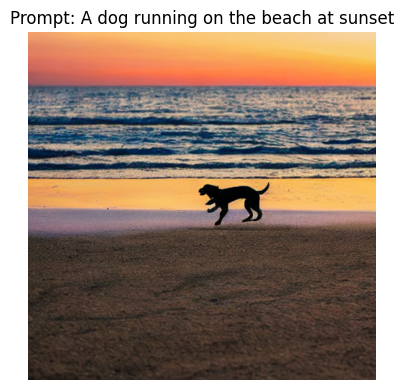

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

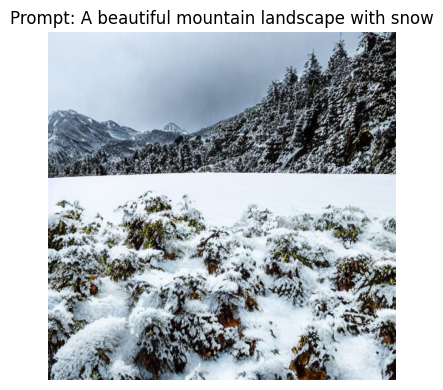

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

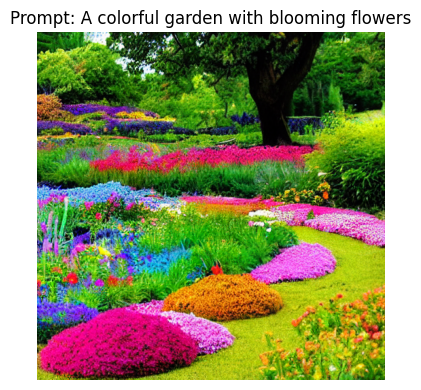

In [ ]:
    # Test the model
    test_prompts = [
        "A dog running on the beach at sunset",
        "A beautiful mountain landscape with snow",
        "A colorful garden with blooming flowers"
    ]

    logger.info("Testing model with sample prompts...")
    for prompt in test_prompts:
        test_model(prompt, num_images=1)

## Testing the Fine-Tuned Model and the model without finetuning and comparing the results

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

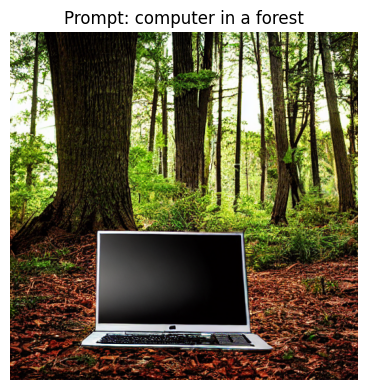

In [49]:
# Fine Tuned Model Results
prompt = 'computer in a forest'
test_model(prompt, num_images=1)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

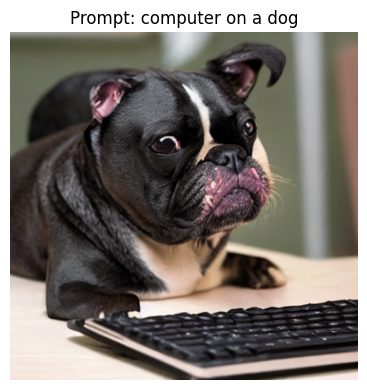

In [50]:
# Fine Tuned Model Results
prompt = 'computer on a dog'
test_model(prompt, num_images=1)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

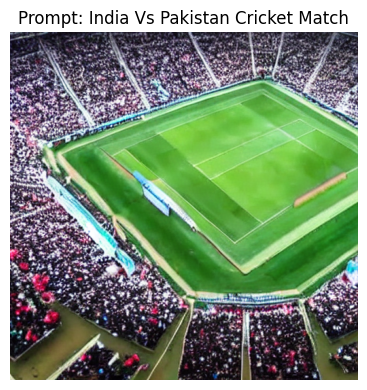

In [51]:
# Fine Tuned Model Results
prompt = 'India Vs Pakistan Cricket Match'
test_model(prompt, num_images=1)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

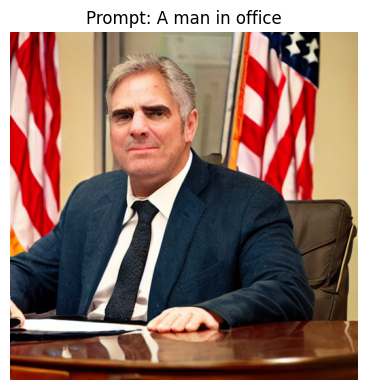

In [52]:
# Fine Tuned Model Results
prompt = 'A man in office'
test_model(prompt, num_images=1)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

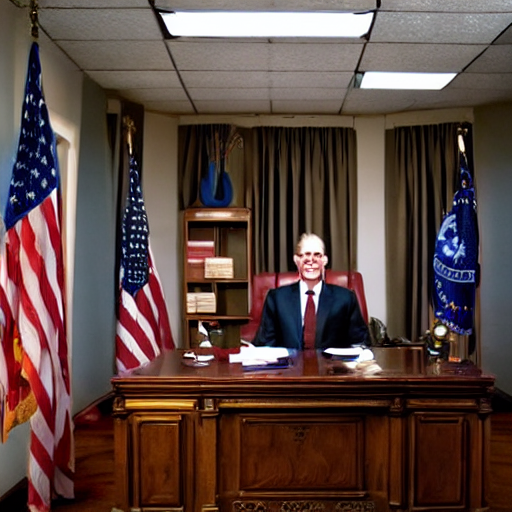

In [53]:
# Original Model Results: Model without Fine-Tuning
import torch
from diffusers import StableDiffusionPipeline
original_pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
     torch_dtype=torch.float16)
original_pipe.to("cuda")
prompt = "A man in office"
image = original_pipe(
    prompt, num_inference_steps=50
).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

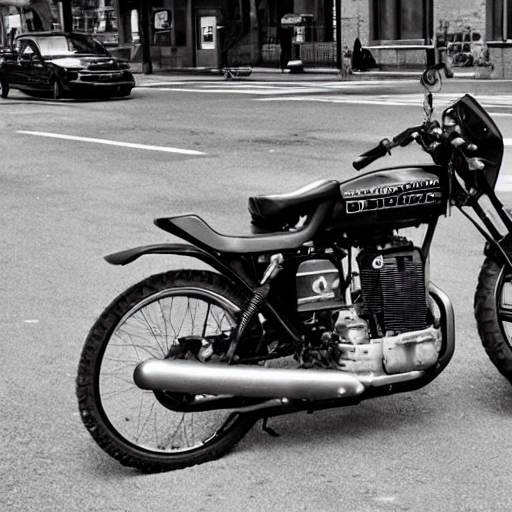

In [58]:
# Original Model Results: Model without Fine-Tuning
prompt = "a motorbike rider"
image = original_pipe(
    prompt, num_inference_steps=50
).images[0]
image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

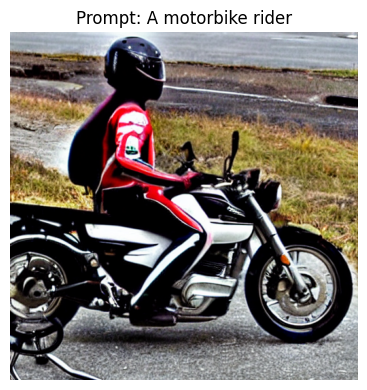

In [55]:
# Fine Tuned Model Results
prompt = 'A motorbike rider'
test_model(prompt, num_images=1)

  0%|          | 0/50 [00:00<?, ?it/s]

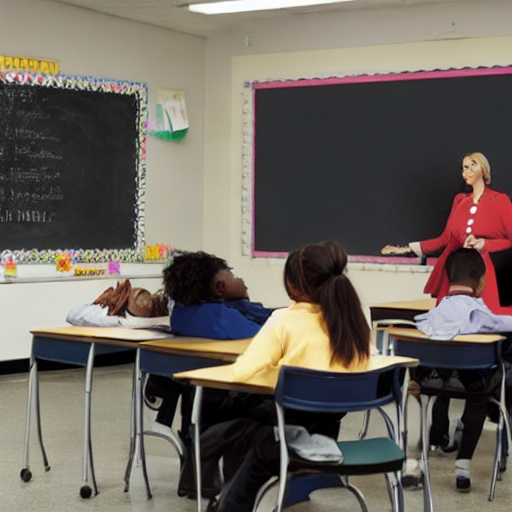

In [56]:
# Original Model Results: Model without Fine-Tuning
prompt = "a teacher teaching a class"
image = original_pipe(
    prompt, num_inference_steps=50
).images[0]
image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

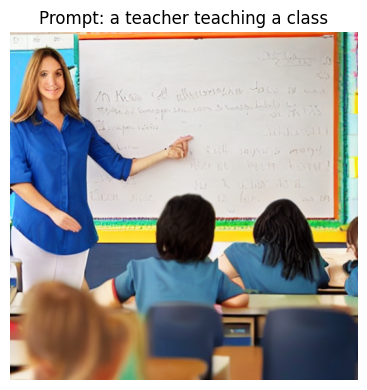

In [57]:
# Fine Tuned Model Results
prompt = 'a teacher teaching a class'
test_model(prompt, num_images=1)

## Commands to download the files after training

In [ ]:
!pip freeze > requirements.txt

In [ ]:
from google.colab import files
files.download('requirements.txt')

In [ ]:
!zip -r dataset.zip dataset/
files.download('dataset.zip')

In [ ]:
!zip -r checkpoints.zip checkpoints/
files.download('checkpoints.zip')

In [ ]:
!zip -r final_model.zip final_model/
files.download('final_model.zip')

In [ ]:
files.download('generated_image_0.png')

In [ ]:
files.download('training_loss.png')